# Lab 5: Spam Detection

**Deadline**: Monday, March 15, 5:00 PM

**Late Penalty**: There is a penalty-free grace period of one hour past the deadline. Any work that is submitted between 1 hour and 24 hours past the deadline will receive a 20% grade deduction. No other late work is accepted. Quercus submission time will be used, not your local computer time. You can submit your labs as many times as you want before the deadline, so please submit often and early.

**TA**: Gautam Dawar <gautam.dawar@mail.utoronto.ca>

In this assignment, we will build a recurrent neural network to classify a SMS text message
as "spam" or "not spam". In the process, you will
    
1. Clean and process text data for machine learning.
2. Understand and implement a character-level recurrent neural network.
3. Use torchtext to build recurrent neural network models.
4. Understand batching for a recurrent neural network, and use torchtext to implement RNN batching.

### What to submit

Submit a PDF file containing all your code, outputs, and write-up. You can produce a PDF of your Google Colab file by going to File > Print and then save as PDF. The Colab instructions have more information (.html files are also acceptable).

Do not submit any other files produced by your code.

Include a link to your colab file in your submission.

## Colab Link

Include a link to your Colab file here. If you would like the TA to look at your
Colab file in case your solutions are cut off, **please make sure that your Colab
file is publicly accessible at the time of submission**.

Colab Link: https://drive.google.com/file/d/18RymUEFHmAze3BXLKCL2GSI3x6nnLNpZ/view?usp=sharing

In [38]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

## Part 1. Data Cleaning [15 pt]

We will be using the "SMS Spam Collection Data Set" available at http://archive.ics.uci.edu/ml/datasets/SMS+Spam+Collection

There is a link to download the "Data Folder" at the very top of the webpage. Download the zip file, unzip it, and upload the file `SMSSpamCollection` to Colab.    

In [39]:
#Loading SMSSpamCollection to Colab
from google.colab import files
filesUpload = files.upload()

Saving SMSSpamCollection to SMSSpamCollection (1)


### Part (a) [2 pt]

Open up the file in Python, and print out one example of a spam SMS, and one example of a non-spam SMS.

What is the label value for a spam message, and what is the label value for a non-spam message?

In [40]:
displayHam = True
for line in open('SMSSpamCollection'):
    if displayHam and line.split()[0] == 'ham':
      print("The label value for a non-spam message:", line.split()[0])
      print("Example of a non-spam: ", line)
      displayHam = False
    elif not displayHam and line.split()[0] == 'spam':
      print("The label value for a spam message:", line.split()[0])
      print("Example of a spam: ", line)
      break

The label value for a non-spam message: ham
Example of a non-spam:  ham	Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...

The label value for a spam message: spam
Example of a spam:  spam	Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's



### Part (b) [1 pt]

How many spam messages are there in the data set?
How many non-spam messages are there in the data set?


In [41]:
spamCount, hamCount = 0, 0

for line in open('SMSSpamCollection'):
  if line.split()[0] == 'spam':
    spamCount += 1
  else:
    hamCount += 1

print('The number of spam messages are:', spamCount)
print('The number of non-spam messages are:', hamCount)

The number of spam messages are: 747
The number of non-spam messages are: 4827


### Part (c) [4 pt]

We will be using the package `torchtext` to load, process, and batch the data.
A tutorial to torchtext is available below. This tutorial uses the same
Sentiment140 data set that we explored during lecture.

https://medium.com/@sonicboom8/sentiment-analysis-torchtext-55fb57b1fab8

Unlike what we did during lecture, we will be building a **character level RNN**.
That is, we will treat each **character** as a token in our sequence,
rather than each **word**.

Identify two advantage and two disadvantage of modelling SMS text
messages as a sequence of characters rather than a sequence of words.

In [ ]:
'''
Advantages of modelling SMS text messages as a sequence of characters rather than a sequence of words:
1) Can account the mis-spelled words and processing abreviations and slang words
2) Can save a lot of memory. This is because there are only a small limited amount of characters
    available. Saving sequences of words requires a lot more memory, as there is a large collection
    of words that can be used. This also means that there is a faster processing of sequence of
    characters, than it would be for sequence of words.

Disdvantages of modelling SMS text messages as a sequence of characters rather than a sequence of words:
1) It is more difficult to understand context and meaning from a sequence of characters than it
    would be for a sequence of words.
2) This will probably require a much larger hidden layer to process each character rather than just
    processing the entire word
'''

### Part (d) [1 pt]

We will be loading our data set using `torchtext.data.TabularDataset`. The
constructor will read directly from the `SMSSpamCollection` file. 

For the data file to be read successfuly, we
need to specify the **fields** (columns) in the file. 
In our case, the dataset has two fields: 

- a text field containing the sms messages,
- a label field which will be converted into a binary label.

Split the dataset into `train`, `valid`, and `test`. Use a 60-20-20 split.
You may find this torchtext API page helpful:
https://torchtext.readthedocs.io/en/latest/data.html#dataset

Hint: There is a `Dataset` method that can perform the random split for you.

In [42]:
import torchtext

text_field = torchtext.legacy.data.Field(sequential=True,      # text sequence
                                  tokenize=lambda x: x, # because are building a character-RNN
                                  include_lengths=True, # to track the length of sequences, for batching
                                  batch_first=True,
                                  use_vocab=True)       # to turn each character into an integer index
label_field = torchtext.legacy.data.Field(sequential=False,    # not a sequence
                                   use_vocab=False,     # don't need to track vocabulary
                                   is_target=True,      
                                   batch_first=True,
                                   preprocessing=lambda x: int(x == 'spam')) # convert text to 0 and 1

fields = [('label', label_field), ('sms', text_field)]
dataset = torchtext.legacy.data.TabularDataset("SMSSpamCollection", # name of the file
                                        "tsv",               # fields are separated by a tab
                                        fields)

print(dataset[0].sms)
print(dataset[0].label)

train, valid, test = dataset.split([0.6, 0.2, 0.2], True)

print("The length of training data:", len(train))
print("The length of validation data:", len(valid))
print("The length of testing data:", len(test))

Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...
0
The length of training data: 3343
The length of validation data: 1115
The length of testing data: 1114


### Part (e) [2 pt]

You saw in part (b) that there are many more non-spam messages than spam messages.
This **imbalance** in our training data will be problematic for training.
We can fix this disparity by duplicating spam messages in the training set,
so that the training set is roughly **balanced**.

Explain why having a balanced training set is helpful for training our neural network.

Note: if you are not sure, try removing the below code and train your mode.

In [43]:
# save the original training examples
old_train_examples = train.examples
# get all the spam messages in `train`
train_spam = []
for item in train.examples:
    if item.label == 1:
        train_spam.append(item)
# duplicate each spam message 6 more times
train.examples = old_train_examples + train_spam * 6

spamCount = len(train_spam) * 6

print("The new length of training set:", len(train.examples))
print("The new count of spam in the training set:", spamCount)
print("The new count of spam in the training set:", len(train.examples) - spamCount, '\n')
'''
Having a balanced training set is very helpful to remove bias in our neural network. When the training
set is unbalanced with 4827 non-spam out of 5574 total samples. This means currently the neural
network can achieve 86.6% accuracy by guessing non-spam each time. This high accuracy doesn't mean
that our model is any good. It just means that the model is just picking the option that dominated our
data. Balancing the training set, and having the model train on equal amounts of spam and non-spam
messages allows for the model to actually learn the differences between two to be able to accurately 
determine spam.
'''

The new length of training set: 6031
The new count of spam in the training set: 2688
The new count of spam in the training set: 3343 



"\nHaving a balanced training set is very helpful to remove bias in our neural network. When the training\nset is unbalanced with 4827 non-spam out of 5574 total samples. This means currently the neural\nnetwork can achieve 86.6% accuracy by guessing non-spam each time. This high accuracy doesn't mean\nthat our model is any good. It just means that the model is just picking the option that dominated our\ndata. Balancing the training set, and having the model train on equal amounts of spam and non-spam\nmessages allows for the model to actually learn the differences between two to be able to accurately \ndetermine spam.\n"

### Part (f) [1 pt]

We need to build the vocabulary on the training data by running the below code.
This finds all the possible character tokens in the training set.

Explain what the variables `text_field.vocab.stoi` and `text_field.vocab.itos` represent.

In [44]:
text_field.build_vocab(train)
text_field.vocab.stoi
text_field.vocab.itos

['<unk>',
 '<pad>',
 ' ',
 'e',
 'o',
 't',
 'a',
 'n',
 'r',
 'i',
 's',
 'l',
 'u',
 'h',
 '0',
 'd',
 '.',
 'c',
 'm',
 'y',
 'w',
 'p',
 'g',
 '1',
 'f',
 '2',
 'b',
 'T',
 '8',
 'k',
 'v',
 'E',
 '5',
 'S',
 'C',
 'I',
 'O',
 '4',
 'N',
 '7',
 'x',
 '3',
 'A',
 '6',
 'R',
 '!',
 ',',
 '9',
 'W',
 'M',
 'P',
 'U',
 'L',
 'H',
 'D',
 'B',
 'G',
 'Y',
 "'",
 'F',
 '?',
 '/',
 '£',
 '-',
 '&',
 ':',
 'X',
 'z',
 'V',
 'j',
 '*',
 'K',
 ')',
 '+',
 'J',
 ';',
 '(',
 'Q',
 'q',
 '"',
 '#',
 '>',
 '=',
 '@',
 'Z',
 'ü',
 'Ü',
 '$',
 '\x92',
 '‘',
 '|',
 '%',
 '[',
 ']',
 '_',
 '<',
 '¡',
 '…',
 '\x93',
 '–',
 '“',
 '\x94',
 'é',
 '~',
 '’',
 '\\',
 '\x96',
 'É']

The variable text_field.vocab.stoi represents the mapping of of strings to numerical identifiers. In our case, each of the characters is mapped to a number.

The variable text_field.vocab.itos represents the strings indexed by their numerical identifiers. In our case, this is the list of characters in stoi with the same order.

### Part (g) [2 pt]

The tokens `<unk>` and `<pad>` were not in our SMS text messages.
What do these two values represent?

In [ ]:
'''
<unk> represents unknown characters.
<pad> represents the padding token which is used to increase the size of the data items.
'''

### Part (h) [2 pt]

Since text sequences are of variable length, `torchtext` provides a `BucketIterator` data loader,
which batches similar length sequences together. The iterator also provides functionalities to
pad sequences automatically.

Take a look at 10 batches in `train_iter`. What is the maximum length of the
input sequence in each batch? How many `<pad>` tokens are used in each of the 10
batches?

In [45]:
train_iter = torchtext.legacy.data.BucketIterator(train,
                                           batch_size=32,
                                           sort_key=lambda x: len(x.sms), # to minimize padding
                                           sort_within_batch=True,        # sort within each batch
                                           repeat=False)                  # repeat the iterator for many epochs

In [46]:
count = 0
for batch in train_iter:
  if count >= 10:
    break
  else:
    maxLength = max(batch.sms[1]).item()
    print("The batch number is:", count)
    print("The max length of the input sequence in this batch is:", maxLength)

    padSum = 0
    for message in batch.sms[0]:
      for pad in message:
        if pad == 1:
          padSum += 1
    print("The count of <pad> is:", padSum, '\n')
    count += 1

    #print(len(batch))
    #print(batch.sms)
    #print(batch.label)

The batch number is: 0
The max length of the input sequence in this batch is: 150
The count of <pad> is: 15 

The batch number is: 1
The max length of the input sequence in this batch is: 166
The count of <pad> is: 56 

The batch number is: 2
The max length of the input sequence in this batch is: 154
The count of <pad> is: 10 

The batch number is: 3
The max length of the input sequence in this batch is: 29
The count of <pad> is: 28 

The batch number is: 4
The max length of the input sequence in this batch is: 85
The count of <pad> is: 56 

The batch number is: 5
The max length of the input sequence in this batch is: 139
The count of <pad> is: 21 

The batch number is: 6
The max length of the input sequence in this batch is: 66
The count of <pad> is: 61 

The batch number is: 7
The max length of the input sequence in this batch is: 158
The count of <pad> is: 0 

The batch number is: 8
The max length of the input sequence in this batch is: 130
The count of <pad> is: 34 

The batch numb

## Part 2. Model Building [8 pt]

Build a recurrent neural network model, using an architecture of your choosing. 
Use the one-hot embedding of each character as input to your recurrent network.
Use one or more fully-connected layers to make the prediction based on your
recurrent network output.

Instead of using the RNN output value for the final token, another often used
strategy is to max-pool over the entire output array. That is, instead of calling
something like:

```
out, _ = self.rnn(x)
self.fc(out[:, -1, :])
```

where `self.rnn` is an `nn.RNN`, `nn.GRU`, or `nn.LSTM` module, and `self.fc` is a 
fully-connected 
layer, we use:

```
out, _ = self.rnn(x)
self.fc(torch.max(out, dim=1)[0])
```

This works reasonably in practice. An even better alternative is to concatenate the
max-pooling and average-pooling of the RNN outputs:

```
out, _ = self.rnn(x)
out = torch.cat([torch.max(out, dim=1)[0], 
                 torch.mean(out, dim=1)], dim=1)
self.fc(out)
```

We encourage you to try out all these options. The way you pool the RNN outputs
is one of the "hyperparameters" that you can choose to tune later on.

In [47]:
# You might find this code helpful for obtaining
# PyTorch one-hot vectors.

ident = torch.eye(10)
print(ident[0]) # one-hot vector
print(ident[1]) # one-hot vector
x = torch.tensor([[1, 2], [3, 4]])
print(ident[x]) # one-hot vectors

tensor([1., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
tensor([0., 1., 0., 0., 0., 0., 0., 0., 0., 0.])
tensor([[[0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]]])


In [48]:
class SpamDetectionRNN(nn.Module):
  def __init__(self, input_size, hidden_size, num_classes):
    super(SpamDetectionRNN, self).__init__()
    self.emb = torch.eye(input_size)
    self.hidden_size = hidden_size
    self.rnn = nn.RNN(input_size, hidden_size, batch_first= True)
    self.fc = nn.Linear(hidden_size*2, num_classes)

  def forward(self, x):
    # Look up the embedding
    x = self.emb[x]
    # Set an initial hidden state
    h0 = torch.zeros(1, x.size(0), self.hidden_size)
    # Forward pass propagate the RNN
    out, _ = self.rnn(x, h0)
    # Pass the output from the last time step to the classifier
    out = self.fc(torch.cat([torch.max(out, dim=1)[0], 
                 torch.mean(out, dim=1)], dim=1))
    return out

## Part 3. Training [16 pt]

### Part (a) [4 pt]

Complete the `get_accuracy` function, which will compute the
accuracy (rate) of your model across a dataset (e.g. validation set).
You may modify `torchtext.data.BucketIterator` to make your computation
faster.

In [49]:
def get_accuracy(model, data, batch_size):
    """ Compute the accuracy of the `model` across a dataset `data`
    
    Example usage:
    
    >>> model = MyRNN() # to be defined
    >>> get_accuracy(model, valid) # the variable `valid` is from above
    """
    # Setting up the data loader
    # Minimizing padding. Sorting within each batch. Not repeating the iterator for many epochs
    dataLoader = torchtext.legacy.data.BucketIterator(data, batch_size=batch_size, sort_key= lambda x: len(x.sms),
                                               sort_within_batch = True, repeat = False)

    correct, total = 0, 0

    for messages, labels in dataLoader:
      output = model(messages[0])
      prediction = output.max(1, keepdim = True)[1]
      correct += prediction.eq(labels.view_as(prediction)).sum().item()
      total += labels.shape[0]

    return correct / total


### Part (b) [4 pt]

Train your model. Plot the training curve of your final model. 
Your training curve should have the training/validation loss and
accuracy plotted periodically.

Note: Not all of your batches will have the same batch size.
In particular, if your training set does not divide evenly by
your batch size, there will be a batch that is smaller than
the rest. 

In [ ]:
def trainRNN(model, training, validation, batch_size=64, num_epochs=15, learning_rate= 1e-4):
  criterion = nn.CrossEntropyLoss()
  optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
  training_losses, validation_losses, training_accuracy, validation_accuracy = [], [], [], []
  epochs = []

  trainingLoader = torchtext.legacy.data.BucketIterator(training, batch_size=batch_size, sort_key= lambda x: len(x.sms),
                                               sort_within_batch = True, repeat = False)
  
  validationLoader = torchtext.legacy.data.BucketIterator(validation, batch_size=batch_size, sort_key= lambda x: len(x.sms),
                                               sort_within_batch = True, repeat = False)

  for epoch in range(num_epochs):
    for messages, labels in trainingLoader:
      optimizer.zero_grad()
      prediction = model(messages[0])
      loss = criterion(prediction, labels)
      loss.backward()
      optimizer.step()
    training_losses.append(float(loss))

    for messages, labels in validationLoader:
      prediction = model(messages[0])
      loss = criterion(prediction, labels)
    validation_losses.append(float(loss))

    epochs.append(epoch)
    
    training_accuracy.append(get_accuracy(model, training, batch_size))
    validation_accuracy.append(get_accuracy(model, validation, batch_size))

    print("Epoch:", epoch + 1, ", Training Accuracy:", training_accuracy[-1], ", Validation Accuracy:", validation_accuracy[-1])

'''
  #Accuracy Plot
  plt.title("Training Curve")
  plt.plot(training_accuracy, label='Training')
  plt.plot(validation_accuracy, label='Validation')
  plt.xlabel('Iterations')
  plt.ylabel('Accuracy')
  plt.show()

  #Loss Plot
  plt.title('Training Curve')
  plt.plot(training_losses, label='Training')
  plt.plot(validation_losses, label='Validation')
  plt.xlabel('Iterations')
  plt.ylabel('Loss')
  plt.show()
'''

Epoch: 1 , Training Accuracy: 0.4800198971978113 , Validation Accuracy: 0.8654708520179372
Epoch: 2 , Training Accuracy: 0.4800198971978113 , Validation Accuracy: 0.8654708520179372
Epoch: 3 , Training Accuracy: 0.6738517658763058 , Validation Accuracy: 0.9103139013452914
Epoch: 4 , Training Accuracy: 0.8867517824573039 , Validation Accuracy: 0.8547085201793722
Epoch: 5 , Training Accuracy: 0.9003482009616979 , Validation Accuracy: 0.873542600896861
Epoch: 6 , Training Accuracy: 0.9185872989553971 , Validation Accuracy: 0.9022421524663677
Epoch: 7 , Training Accuracy: 0.9469408058365114 , Validation Accuracy: 0.9291479820627803
Epoch: 8 , Training Accuracy: 0.8585640855579506 , Validation Accuracy: 0.9452914798206278
Epoch: 9 , Training Accuracy: 0.9320179074780301 , Validation Accuracy: 0.9381165919282511
Epoch: 10 , Training Accuracy: 0.9351682971314873 , Validation Accuracy: 0.9479820627802691
Epoch: 11 , Training Accuracy: 0.9305256176421821 , Validation Accuracy: 0.914798206278026

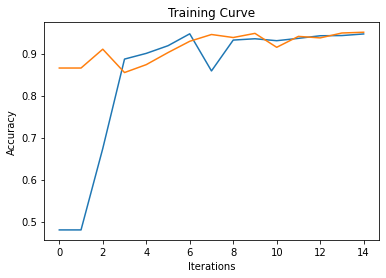

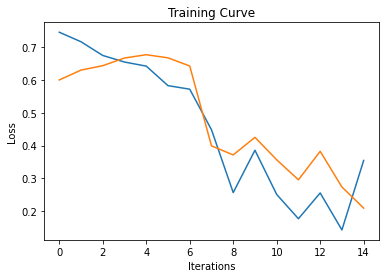

In [68]:
#Running my RNN model for the first time
#hidden_size = 50, num_classes = 2
input_size = len(text_field.vocab.itos)
myModel = SpamDetectionRNN(input_size, hidden_size=50, num_classes=2)
trainRNN(myModel, train, valid, batch_size=64, num_epochs=15, learning_rate=1e-4)

### Part (c) [4 pt]

Choose at least 4 hyperparameters to tune. Explain how you tuned the hyperparameters.
You don't need to include your training curve for every model you trained.
Instead, explain what hyperparemters you tuned, what the best validation accuracy was,
and the reasoning behind the hyperparameter decisions you made.

For this assignment, you should tune more than just your learning rate and epoch. 
Choose at least 2 hyperparameters that are unrelated to the optimizer.

In [14]:
#Running my RNN model for the second time
#Here I will be increasing the number of hidden_size and I will also be decreasing the learning_rate
#Reasoning: Hoping to see more steady results and greater accuracy
#hidden_size = 100, num_classes = 2
#batch_size = 64, num_epochs = 15, learning_rate = 1e-5
input_size = len(text_field.vocab.itos)
mySecondModel = SpamDetectionRNN(input_size, hidden_size=100, num_classes=2)
trainRNN(mySecondModel, train, valid, batch_size=64, num_epochs=15, learning_rate=1e-5)

Epoch: 1 , Training Accuracy: 0.4800198971978113 , Validation Accuracy: 0.8654708520179372
Epoch: 2 , Training Accuracy: 0.4800198971978113 , Validation Accuracy: 0.8654708520179372
Epoch: 3 , Training Accuracy: 0.4816779970154203 , Validation Accuracy: 0.8663677130044843
Epoch: 4 , Training Accuracy: 0.5703863372575029 , Validation Accuracy: 0.8798206278026905
Epoch: 5 , Training Accuracy: 0.6128336925882938 , Validation Accuracy: 0.884304932735426
Epoch: 6 , Training Accuracy: 0.793566572707677 , Validation Accuracy: 0.8941704035874439
Epoch: 7 , Training Accuracy: 0.8452992870170785 , Validation Accuracy: 0.8860986547085202
Epoch: 8 , Training Accuracy: 0.7925717128171116 , Validation Accuracy: 0.7067264573991031
Epoch: 9 , Training Accuracy: 0.8040126015586139 , Validation Accuracy: 0.7309417040358744
Epoch: 10 , Training Accuracy: 0.7643840159177583 , Validation Accuracy: 0.6322869955156951
Epoch: 11 , Training Accuracy: 0.7201127507875974 , Validation Accuracy: 0.5354260089686098

In [35]:
#Running my RNN model for the third time
#Here I will be increasing the number of epochs and I will also be increasing the learning rate
#Reasoning: Based on my second model, my results significantly declined. I'm hoping to retain
#a high accuracy and provide a longer training period to see more stability.
#hidden_size = 100, num_classes = 2
#batch_size = 64, num_epochs = 20, learning_rate = 1e-4
input_size = len(text_field.vocab.itos)
myThirdModel = SpamDetectionRNN(input_size, hidden_size=100, num_classes=2)
trainRNN(myThirdModel, train, valid, batch_size=64, num_epochs=20, learning_rate=1e-4)

Epoch: 1 , Training Accuracy: 0.576852926546178 , Validation Accuracy: 0.19282511210762332
Epoch: 2 , Training Accuracy: 0.5365611009782789 , Validation Accuracy: 0.15784753363228698
Epoch: 3 , Training Accuracy: 0.6259326811474051 , Validation Accuracy: 0.2538116591928251
Epoch: 4 , Training Accuracy: 0.8597247554302769 , Validation Accuracy: 0.9121076233183857
Epoch: 5 , Training Accuracy: 0.9107942298126347 , Validation Accuracy: 0.9085201793721973
Epoch: 6 , Training Accuracy: 0.9446194660918588 , Validation Accuracy: 0.947085201793722
Epoch: 7 , Training Accuracy: 0.9439562261648151 , Validation Accuracy: 0.9515695067264573
Epoch: 8 , Training Accuracy: 0.9490963355994031 , Validation Accuracy: 0.9551569506726457
Epoch: 9 , Training Accuracy: 0.9504228154534903 , Validation Accuracy: 0.9596412556053812
Epoch: 10 , Training Accuracy: 0.9381528768031836 , Validation Accuracy: 0.905829596412556
Epoch: 11 , Training Accuracy: 0.9580500746144918 , Validation Accuracy: 0.965919282511210

In [26]:
#Running my RNN model for the fourth time
#Reflection: In the last iteration, I had the best validation accuracy so far of 96.9%
#Reasoning: Now I will try to use the RNN raw output value for the final token instead of concatenated
#max-pooling and average-pooling layers which I have used until now. I understand that those work better
#better in practice. But I want to confirm this theory and test whether my validation accuracy is now 
#reduced due to this change

'''
class SpamDetectionRNN(nn.Module):
  def __init__(self, input_size, hidden_size, num_classes):
    super(SpamDetectionRNN, self).__init__()
    self.emb = torch.eye(input_size)
    self.hidden_size = hidden_size
    self.rnn = nn.RNN(input_size, hidden_size, batch_first= True)
    self.fc = nn.Linear(hidden_size, num_classes)

  def forward(self, x):
    # Look up the embedding
    x = self.emb[x]
    # Set an initial hidden state
    h0 = torch.zeros(1, x.size(0), self.hidden_size)
    # Forward pass propagate the RNN
    out, _ = self.rnn(x, h0)
    # Pass the output from the last time step to the classifier
    out = self.fc(out[:, -1, :])
    return out
'''

#hidden_size = 100, num_classes = 2
#batch_size = 64, num_epochs = 20, learning_rate = 1e-5
input_size = len(text_field.vocab.itos)
myThirdModel = SpamDetectionRNN(input_size, hidden_size=100, num_classes=2)
trainRNN(myThirdModel, train, valid, batch_size=64, num_epochs=20, learning_rate=1e-4)

Epoch: 1 , Training Accuracy: 0.6360470900348201 , Validation Accuracy: 0.7076233183856502
Epoch: 2 , Training Accuracy: 0.7398441386171447 , Validation Accuracy: 0.7668161434977578
Epoch: 3 , Training Accuracy: 0.8126347206101807 , Validation Accuracy: 0.7300448430493274
Epoch: 4 , Training Accuracy: 0.7151384513347704 , Validation Accuracy: 0.7201793721973094
Epoch: 5 , Training Accuracy: 0.9185872989553971 , Validation Accuracy: 0.9049327354260089
Epoch: 6 , Training Accuracy: 0.9162659592107445 , Validation Accuracy: 0.9067264573991032
Epoch: 7 , Training Accuracy: 0.9338418172774001 , Validation Accuracy: 0.8995515695067264
Epoch: 8 , Training Accuracy: 0.9318520974962693 , Validation Accuracy: 0.9183856502242153
Epoch: 9 , Training Accuracy: 0.9293649477698558 , Validation Accuracy: 0.9139013452914798
Epoch: 10 , Training Accuracy: 0.925717128171116 , Validation Accuracy: 0.9461883408071748
Epoch: 11 , Training Accuracy: 0.9462775659094678 , Validation Accuracy: 0.935426008968609

After training four models, we can see that the my best model was my third model. This model used the original final token of concatenating the max-pooling and the average-pooling of the RNN outputs. This model also had a dimension of 100 for the hidden units. Lastly, the batch_size was 64, the num_epochs was 20, and the learning_rate was 1e-4. With this architecture and hyperparameter combination, I was able to achieve a validation accuracy of 96.9% Additionally, this result was steady and consistent over the last 3 epochs suggesting this is a good result to end of on.

### Part (d) [2 pt]

Before we deploy a machine learning model, we usually want to have a better understanding
of how our model performs beyond its validation accuracy. An important metric to track is
*how well our model performs in certain subsets of the data*.

In particular, what is the model's error rate amongst data with negative labels?
This is called the **false positive rate**.

What about the model's error rate amongst data with positive labels?
This is called the **false negative rate**.

Report your final model's false positive and false negative rate across the
validation set.

In [50]:
# Create a Dataset of only spam validation examples
valid_spam = torchtext.legacy.data.Dataset(
    [e for e in valid.examples if e.label == 1],
    valid.fields)
# Create a Dataset of only non-spam validation examples
valid_nospam = torchtext.legacy.data.Dataset(
    [e for e in valid.examples if e.label == 0],
    valid.fields)

#Final Model = myThirdModel
#hidden_size = 100, num_classes = 2
#batch_size = 64, num_epochs = 20, learning_rate = 1e-4
falsePositiveRate = 1 - get_accuracy(myThirdModel, valid_nospam, 64)
falseNegativeRate = 1 - get_accuracy(myThirdModel, valid_spam, 64)

print("The Final Model's false positive rate across the validation set is:", falsePositiveRate*100, "%")
print("The Final Model's false negative rate across the validation set is:", falseNegativeRate*100, "%")

The Final Model's false positive rate across the validation set is: 2.2797927461139844 %
The Final Model's false negative rate across the validation set is: 6.666666666666665 %


### Part (e) [2 pt]

The impact of a false positive vs a false negative can be drastically different.
If our spam detection algorithm was deployed on your phone, what is the impact
of a false positive on the phone's user? What is the impact of a false negative?

In [ ]:
'''
The impact of a false positive is that the user's phone could falsely detect spam information as 
non-spam. This will annoy the user as these spam messages will still go through and go to the user.

The impact of false negatives is that the user's phone could falsely detect non-spam information as
spam and prevent the user from recieving this information. This could be problematic because potentially
important information could be blocked from the user and could frustrate the user.
'''

## Part 4. Evaluation [11 pt]

### Part (a) [1 pt]

Report the final test accuracy of your model.

In [51]:
finalTestAccuracy = get_accuracy(myThirdModel, test, 64)
print("The final test accuracy is:", finalTestAccuracy)

The final test accuracy is: 0.9703770197486535


### Part (b) [3 pt]

Report the false positive rate and false negative rate of your model across the test set.

In [54]:
# Create a Dataset of only spam testing examples
test_spam = torchtext.legacy.data.Dataset(
    [e for e in test.examples if e.label == 1],
    test.fields)
# Create a Dataset of only non-spam testing examples
test_nospam = torchtext.legacy.data.Dataset(
    [e for e in test.examples if e.label == 0],
    test.fields)

#Final Model = myThirdModel
#hidden_size = 100, num_classes = 2
#batch_size = 64, num_epochs = 20, learning_rate = 1e-4
falsePositiveRate = 1 - get_accuracy(myThirdModel, test_nospam, 64)
falseNegativeRate = 1 - get_accuracy(myThirdModel, test_spam, 64)

print("The Final Model's false positive rate across the testing set is:", falsePositiveRate*100, "%")
print("The Final Model's false negative rate across the testing set is:", falseNegativeRate*100, "%")

The Final Model's false positive rate across the testing set is: 2.1761658031088094 %
The Final Model's false negative rate across the testing set is: 8.053691275167784 %


### Part (c) [3 pt]

What is your model's prediction of the **probability** that
the SMS message "machine learning is sooo cool!" is spam?

Hint: To begin, use `text_field.vocab.stoi` to look up the index
of each character in the vocabulary.

In [56]:
msg = "machine learning is sooo cool!"

msgIndex = []

for i in msg:
  idx = text_field.vocab.stoi[i]
  msgIndex.append(idx)

msgTensor = torch.tensor(msgIndex).unsqueeze(0)
prediction = myThirdModel(msgTensor)
prediction = F.softmax(prediction, dim=1)

print(prediction)

tensor([[0.9406, 0.0594]], grad_fn=<SoftmaxBackward>)


This means that my best model predicts that the probability that this message is spam is: 5.94%. This means that my model believes that this is not a spam message.

### Part (d) [4 pt]

Do you think detecting spam is an easy or difficult task?

Since machine learning models are expensive to train and deploy, it is very
important to compare our models against baseline models: a simple
model that is easy to build and inexpensive to run that we can compare our
recurrent neural network model against.

Explain how you might build a simple baseline model. This baseline model
can be a simple neural network (with very few weights), a hand-written algorithm,
or any other strategy that is easy to build and test.

**Do not actually build a baseline model. Instead, provide instructions on
how to build it.**

In [ ]:
'''
I think that detecting spam is not an easy task. This is because spam can come in many shapes and sizes.
Even though I was able to detect spam with a testing accuracy of 97%, there are still a lot of false
positives and false negatives. Even though it may seem that this percentage isn't very, it may be
crucial to achieve lower chances for error especially for more important work. Additionally, spam 
messages are always evolving and it may be difficult for my model to detect new variances.

My baseline model would be extremely simple and make predictions of whether the message is spam or not
based on the data available. For example, in our data the number of spam messages are: 747 and the number 
of non-spam messages are: 4827. So my model would always predict that the message is not spam to achieve
an accuracy of 86.6%. I would also hard-code some common most popular spam words in my algorithm 
and check whether the message has any of those words and immediately mark those messages as spam. 
With this combination, I would achieve an accuracy in the high 80s which is great for a baseline
model. Then I can compare my model with this model. My model should perform better than model,
because this model is completely guessing and there is not much "machine learning" going on. 
If my model performs worse than this model, I would know that my model is not the best. This baseline
model is a good standard of comparison for any machine learning model.
'''


In [ ]:
%%shell
jupyter nbconvert --to html /content/Lab_5_Spam_Detection.ipynb